In [0]:

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
#Open drugreview files
df_train=pd.read_csv("drugsComTrain_raw.csv")
print("Train Data format " ,df_train.head())
print("Train Data shape ",df_train.shape)
print("Condition count in Train dataset ", df_train['condition'].value_counts())
df_train_cond_rev=df_train[['condition','review']].copy()
df_temp=df_train_cond_rev[pd.notnull(df_train_cond_rev['review'])]
df_train_fil=df_temp[pd.notnull(df_temp['condition'])]
print("Dataset with columns Condition and review" , df_train_fil)
print("Dataset with columns Condition and review dimension " ,df_train_fil.shape)

Train Data format     uniqueID                  drugName  ...       date usefulCount
0    206461                 Valsartan  ...  20-May-12          27
1     95260                Guanfacine  ...  27-Apr-10         192
2     92703                    Lybrel  ...  14-Dec-09          17
3    138000                Ortho Evra  ...   3-Nov-15          10
4     35696  Buprenorphine / naloxone  ...  27-Nov-16          37

[5 rows x 7 columns]
Train Data shape  (161297, 7)
Condition count in Train dataset  Birth Control                                              28788
Depression                                                  9069
Pain                                                        6145
Anxiety                                                     5904
Acne                                                        5588
                                                           ...  
Cogan's Syndrome                                               1
95</span> users found this comment helpful. 

In [4]:
# Clean patient condition label with bad data
df_comment = df_train_fil[df_train_fil['condition'].str.contains('comment')]
df_comment

,condition,review
105,2</span> users found this comment helpful.,"""I&#039;m 16 and I have been on Loestrin 24 f..."
196,4</span> users found this comment helpful.,"""I&#039;m 24 years old and have always had a p..."
243,3</span> users found this comment helpful.,"""I took Yaz for a little over 2 years. From a..."
264,4</span> users found this comment helpful.,"""Took this pill for 1.) Acne and 2.) Birth Con..."
391,11</span> users found this comment helpful.,"""I have suffered with low back pain - 2 surger..."
...,...,...
160322,99</span> users found this comment helpful.,"""Great pill... You can definitely see it worki..."
160791,62</span> users found this comment helpful.,"""I am sharing a painful experience actually. T..."
160899,7</span> users found this comment helpful.,"""I&#039;ve been taking Geodon for about a mont..."
160921,92</span> users found this comment helpful.,"""At 300mg 4x daily my pain was almost gone. """


In [5]:
# Dropping rows that contain incorrect information 

df_train_fil = df_train_fil[~df_train_fil['condition'].str.contains('comment')]
print(df_train_fil.shape)

(159498, 2)


Birth Control                                   28788
Depression                                       9069
Pain                                             6145
Anxiety                                          5904
Acne                                             5588
                                                ...  
Hypopituitarism                                     1
Hypodermoclysis                                     1
Cerebrovascular Insufficiency                       1
Scleroderma                                         1
Reversal of Nondepolarizing Muscle Relaxants        1
Name: condition, Length: 811, dtype: int64


Text(0.5, 1.0, 'Top 50  : The number of reviews per patient condition.')

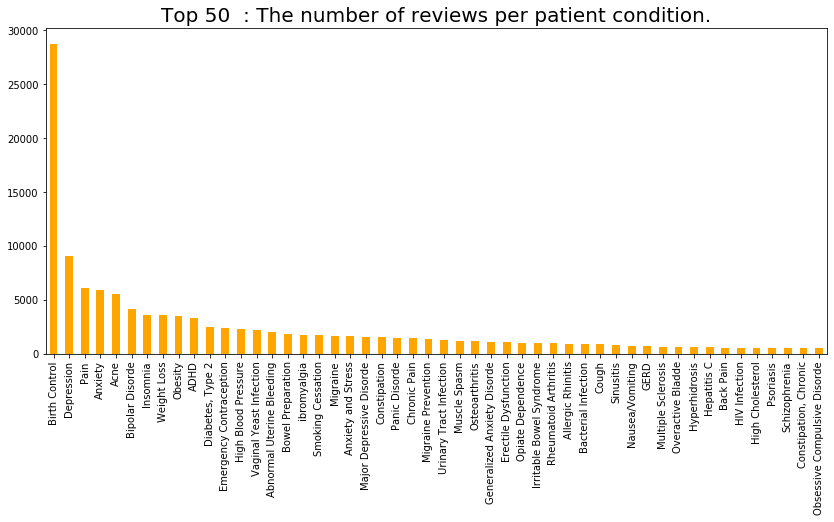

In [6]:
# Data plot based on review and condition
df_condition=df_train_fil.condition.value_counts()
print(df_condition)
df_condition[0:50].plot(kind="bar", figsize = (14,6), fontsize = 10,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 50  : The number of reviews per patient condition.", fontsize = 20)

In [7]:
value_counts=df_train_fil['condition'].value_counts()
# Select the values where the count is less than 3 (or 5 if you like)
print(value_counts)

Birth Control                                   28788
Depression                                       9069
Pain                                             6145
Anxiety                                          5904
Acne                                             5588
                                                ...  
Hypopituitarism                                     1
Hypodermoclysis                                     1
Cerebrovascular Insufficiency                       1
Scleroderma                                         1
Reversal of Nondepolarizing Muscle Relaxants        1
Name: condition, Length: 811, dtype: int64


In [8]:
to_remove = value_counts[value_counts <= 800].index
# Keep rows where the city column is not in to_remove
df_train_fil = df_train_fil[~df_train_fil.condition.isin(to_remove)]
print(" Dataset after removal",df_train_fil.shape)
df_train_fil.condition.value_counts()

 Dataset after removal (114796, 2)


Birth Control                  28788
Depression                      9069
Pain                            6145
Anxiety                         5904
Acne                            5588
Bipolar Disorde                 4224
Insomnia                        3673
Weight Loss                     3609
Obesity                         3568
ADHD                            3383
Diabetes, Type 2                2554
Emergency Contraception         2463
High Blood Pressure             2321
Vaginal Yeast Infection         2274
Abnormal Uterine Bleeding       2096
Bowel Preparation               1859
ibromyalgia                     1791
Smoking Cessation               1780
Migraine                        1694
Anxiety and Stress              1663
Major Depressive Disorde        1607
Constipation                    1595
Panic Disorde                   1463
Chronic Pain                    1455
Migraine Prevention             1413
Urinary Tract Infection         1316
Muscle Spasm                    1244
O

In [0]:

df_train_fil.replace({'condition':{'Generalized Anxiety Disorde': 'Anxiety Disorder','Anxiety and Stress': 'Anxiety Disorder','Anxiety':'Anxiety Disorder','Major Depressive Disorde':'Depression','Pain':'Chronic Pain'}},inplace= True)

In [10]:
df_train_fil.condition.unique()

array(['ADHD', 'Birth Control', 'Opiate Dependence',
       'Emergency Contraception', 'Bipolar Disorde',
       'Migraine Prevention', 'Depression', 'Cough', 'Obesity',
       'Urinary Tract Infection', 'ibromyalgia', 'Insomnia',
       'Rheumatoid Arthritis', 'Vaginal Yeast Infection', 'Panic Disorde',
       'Migraine', 'Chronic Pain', 'Irritable Bowel Syndrome',
       'Osteoarthritis', 'Constipation', 'Bowel Preparation',
       'Muscle Spasm', 'Diabetes, Type 2', 'Smoking Cessation',
       'Anxiety Disorder', 'Acne', 'Erectile Dysfunction',
       'High Blood Pressure', 'Allergic Rhinitis',
       'Abnormal Uterine Bleeding', 'Weight Loss', 'Bacterial Infection',
       'Sinusitis'], dtype=object)

Birth Control                28788
Depression                   10676
Anxiety Disorder              8731
Chronic Pain                  7600
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Constipation                  1595
Panic Disorde                 1463
Migraine Prevention           1413
Urinary Tract Infection       1316
Muscle Spasm                  1244
Osteoarthritis                1239
Erectile Dysfunction          1086
Opiate Dependence             1079
Irritable Bowel Syndrome      1014
Rheumatoid Arthritis

Text(0.5, 1.0, 'Top 33  : The number of reviews per patient condition.')

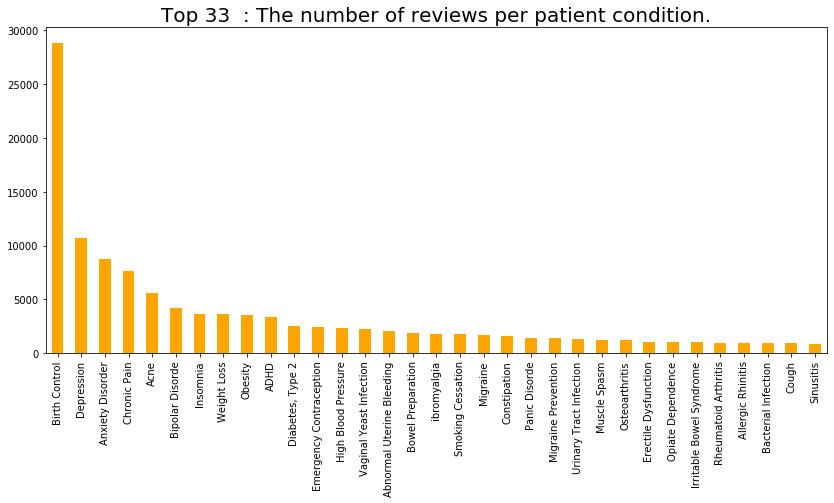

In [11]:
# Data plot based on review and condition
df_condition=df_train_fil.condition.value_counts()
print(df_condition)
df_condition[0:33].plot(kind="bar", figsize = (14,6), fontsize = 10,color="orange")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 33  : The number of reviews per patient condition.", fontsize = 20)

In [12]:
df_train_fil = df_train_fil.sample(frac=0.5, replace=True, random_state=1).copy()
df_train_fil.shape

(57398, 2)

In [13]:
#Clean review comments
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@\d+]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z00-99 #+_]')
add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\','this','will','doctor','took','got','month','an','weight','if','one','week','when','more','are','weeks','are','would','just','feel','day',
 'im','though','daily','found','daily','found','give','7','gained','happy','sure','told','less','gave','three',
 'side','taking','ive','years','first','effects','take','started','like','months','get','days','time','2','feel','would','3',
 'back', 'also','dont','since', 'also','dont','since', 'cant','stop','morning','however','taken','within','see''good','night',
 'even','year','great','ago','4','tried','little','5','dose','used','worked','1','getting','could','10','almost','put','6','use',
 'nothing','far','helped','normal','gain','recommend','without','long','thing','make','many','noticed','said','ood','best',
 'thought','gone','working','couldnt','anything','something','spotting','things','people','second','need','20','way','half',
 'start','another','completely','wasnt','everything','8','face','bit','high','worth','definitely','pretty','decided','actually',
 'lbs','effective','past','today','helps','heavy','new','may','doesnt','30','minutes','15','problem','dry','came','reviews','shot','issues','trying','switched','depressed','12','full','sometimes','find','meds','change','anyone','caused','thats','results','done','increased','twice','energy','fine','several','hard','read','given','pressure','come','clear','eating','already','insurance','everyone','dosage','mouth','amazing','id','enough','wanted','overall','maybe','began','really','still','never','much','work','went','two','didnt','go','made','works','going','mg','hours','last','ever','lost','lot','try','think','stopped',
 'away','know','times','always','havent','next','due','want','around','experienced','finally','able','right','later','different','hour','keep','dr','changed','makes','least','else','difference','seems','needed','product',
 'point','soon','absolutely','anymore','usually','drink','free','stay','became','recently','awful','small','hoping','believe','felt','better','good','every','well','help','feeling','prescribed','severe','experience','using','effect','worse','body','old','love','see','symptoms','eat','drive','problems','light','starting','insertion','attacks','hope','bed','plan','negative','crazy','major','9','whole','gotten','quit','removed','extreme','food','pack','lasted','end','patch','everyday','constant','person','25','reason','others','medications','thoughts','24','yet','tell','reading','etc','regular','although','suffered','cause','10mg','along','asleep','wake','remember','medicines','100','doctors','hair','left','immediately','hurt','part','constantly','school','per','highly','burning','mind','break','positive','b','super','slight','big','short','head','notice','probably','cycle','deal','cleared','either','woke','seem','wish','increase','wait','boyfriend','let','four','50','18','wouldnt','scared','23','20mg','quite','stuff','continue','takes','thinking','literally','worry','beginning','might','recommended','treatment','early','plus','experiencing','taste','home','seemed','huge','ended','kept','easy','husband','doc','hungry','suffer','crying','wont','third','switch','except','become','isnt','prescription','making','16','coming','family','40','fall','yes','goes','luck','quickly','entire','2015','currently','looking','fast','glad','fatigue','attack','please','straight','yrs','2nd','can','not','thank','dreams','withdrawal','trouble','3rd','cream','happened','fact','function','care','often','kind','50mg','hate','kids','amount','late','especially','instead','gets','switching','wonderful','issue','changes','losing','chest','saved','broke','level','worried','live','totally','loved','14','lighter','type','active','nearly','age','prior','feels','intense','real','1st','son','45','rather','baby','decreased','improved','slowly','someone','focus','self','lots','size','normally','5mg','hospital','irregular','six','yesterday','nervous','rest','cry','uncomfortable','supposed','hopefully','guess','drinking','procedure','knew','called','improvement','giving','11','34','youre','walk','form','asked','slightly','developed','bathroom','expensive','suggested','17','look','okay','sleepy','ok','eventually','course','add','2016','knee','stick','must','brand','five','sensitive','health','wonders','minor','child','comes','none','breakouts','hasnt','adderall','saw','cost','review','unfortunately','red','100mg','leave','affects','occasional','helping','hot','breakthrough','serious','possible','usual','zero','single','pay','perfect','levels','hell','nights','sad','legs','total','friends','handle','doses','seen','difficult','prep','easily','13','throughout','slept','minimal','god','social','continued','turned','mine','reduced','seeing','strong','term','ready','truly','upset','happen','lasts','unbearable','wrong','rid','mostly','evening','says','unprotected','march','case','children','place','25mg','vyvanse','moderate','awesome','pm','reaction','post','60','female','causing','higher','easier']

STOPWORDS = set(stopwords.words('english'))
stop_words=STOPWORDS.union(add_stop)
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
        # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stop_words) # delete stopwors from text
    return text
    
df_train_fil['review'] = df_train_fil['review'].apply(clean_text)
#print_plot(10)
df_train_fil

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,condition,review
138414,Chronic Pain,neurontin nerve pain associated paralysis leg ...
109133,Depression,depression psychology study suicidal selfcontr...
7319,ibromyalgia,lyrica pain walking pillows dizzy drunk lose p...
137741,Bipolar Disorde,psychotic diagnosis bipolar mood stabilizer ru...
70413,Birth Control,close together sake sanity remembering pills s...
...,...,...
76462,"Diabetes, Type 2",discontinued horrible throwing spent iv fluids...
94780,Emergency Contraception,ella protected sex condom sleep running wild f...
114328,Depression,slipped suicidal ideations rheumatological dis...
4350,Birth Control,bc mood swings weak tiredbut nexplanon blame a...


In [14]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
reviews = df_train_fil.review.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:200]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
34339


['pain',
 'pill',
 'period',
 'anxiety',
 'bad',
 'medication',
 'life',
 'control',
 'acne',
 'birth',
 'depression',
 'medicine',
 'sleep',
 'mood',
 'periods',
 'bleeding',
 'sex',
 'cramps',
 'drug',
 'skin',
 'nausea',
 'pills',
 'horrible',
 'pounds',
 'swings',
 'blood',
 'headaches',
 'panic',
 'stomach',
 'worst',
 'couple',
 'pregnant',
 'cramping',
 'appetite',
 'painful',
 'loss',
 'terrible',
 'tired',
 'extremely',
 'longer',
 'water',
 'migraines',
 'relief',
 'th',
 'inserted',
 'headache',
 'low',
 'mirena',
 'ill',
 'mild',
 'lose',
 'lexapro',
 'insomnia',
 'infection',
 'nexplanon',
 'med',
 'pregnancy',
 'sick',
 'diagnosed',
 'disorder',
 'sleeping',
 'exercise',
 'migraine',
 'x',
 'nauseous',
 'zoloft',
 'diet',
 'job',
 'heart',
 'lower',
 'bc',
 'iud',
 'chronic',
 'emotional',
 'implanon',
 'diarrhea',
 'miracle',
 'xanax',
 'bipolar',
 'stress',
 'implant',
 'constipation',
 'cymbalta',
 'anxious',
 'moody',
 'er',
 'dizzy',
 'muscle',
 'generic',
 'nd',
 's

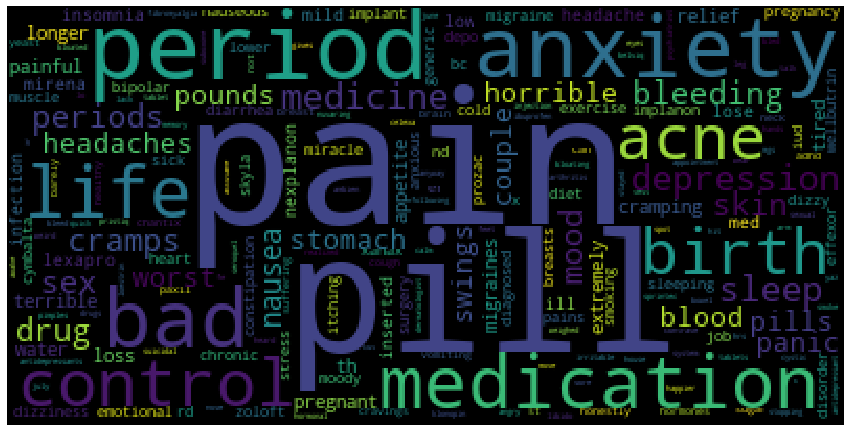

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.figure( figsize=(15,8) )
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [16]:
df_train_fil.review.describe()

count     57398
unique    39165
top            
freq        447
Name: review, dtype: object

In [17]:
# Create a new column 'category_id' with encoded categories 
df_train_fil['condition_id'] = df_train_fil['condition'].factorize()[0]
category_id_df = df_train_fil[['condition', 'condition_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['condition_id', 'condition']].values)

# New dataframe
df_train_fil.condition_id.value_counts()

4     14362
1      5387
16     4431
0      3779
24     2744
3      2064
6      1913
13     1769
9      1718
12     1709
7      1266
11     1220
10     1172
15     1154
31      996
17      973
2       914
23      882
19      845
28      799
18      724
29      681
5       662
14      627
21      600
8       567
26      559
27      537
20      510
22      488
30      472
25      456
32      418
Name: condition_id, dtype: int64

In [18]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py 

--2019-11-29 06:53:27--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   117MB/s    in 3.3s    

2019-11-29 06:53:31 (117 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

--2019-11-29 06:53:33--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [tex

In [19]:
import modeling
import optimization
import run_classifier
import tokenization

In [0]:
import zipfile
folder = 'model_folder'
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)

In [21]:
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'
print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: model_folder/outputs
>>  BERT pretrained directory: model_folder/uncased_L-12_H-768_A-12


In [22]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [23]:
df3=pd.DataFrame()
df3["Text"] = df_train_fil["review"]
df3["Label"] = df_train_fil["condition_id"]
print(df3)

                                                     Text  Label
138414  neurontin nerve pain associated paralysis leg ...      0
109133  depression psychology study suicidal selfcontr...      1
7319    lyrica pain walking pillows dizzy drunk lose p...      2
137741  psychotic diagnosis bipolar mood stabilizer ru...      3
70413   close together sake sanity remembering pills s...      4
...                                                   ...    ...
76462   discontinued horrible throwing spent iv fluids...      7
94780   ella protected sex condom sleep running wild f...     11
114328  slipped suicidal ideations rheumatological dis...      1
4350    bc mood swings weak tiredbut nexplanon blame a...      4
65793   bc typically period period cramps pain thresho...      4

[57398 rows x 2 columns]


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df3["Text"].values, df3["Label"].values, test_size=0.2, random_state=42)

In [26]:
import os
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 12
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 250
# Model configs
SAVE_CHECKPOINTS_STEPS = 500000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

label_list = [str(num) for num in range(33)]
##Anoop changes
print(label_list)
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
INFO:tensorflow:Using config: {'_model_dir': 'model_folder/outputs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0f007f02b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_maste

In [0]:
##Anoop changes
from datetime import time
print(label_list)
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
#print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print('>> Finished training at {}'.format(datetime.datetime.now()))

In [0]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    #batch_size = 500
    batch_size=8
    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [29]:
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

INFO:tensorflow:Writing example 0 of 11480
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] mixed honestly everyone ##s react differently sprint ##ec react medication cheap ##est birth control you ##sw ##itch [SEP]
INFO:tensorflow:input_ids: 101 3816 9826 3071 2015 10509 11543 9043 8586 10509 14667 10036 4355 4182 2491 2017 26760 20189 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [30]:
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 250)
INFO:tensorflow:  name = input_mask, shape = (?, 250)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 250)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (30522, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encode

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
print("Accuracy of BERT is:",accuracy_score(y_test,preds))

Accuracy of BERT is: 0.8109756097560976


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       742
           1       0.70      0.75      0.72      1060
           2       0.80      0.66      0.72       195
           3       0.83      0.75      0.79       426
           4       0.93      0.96      0.95      2943
           5       0.75      0.68      0.71       121
           6       0.80      0.85      0.83       358
           7       0.88      0.84      0.86       276
           8       0.89      0.90      0.90       119
           9       0.62      0.65      0.63       325
          10       0.77      0.80      0.78       227
          11       0.91      0.89      0.90       237
          12       0.86      0.86      0.86       354
          13       0.69      0.63      0.66       356
          14       0.72      0.59      0.65       125
          15       0.87      0.94      0.91       232
          16       0.68      0.76      0.72       834
          17       0.91    